# Hệ thống Trích xuất và Phân tích Tên riêng từ Bài báo Tiếng Việt

## Mô tả
- **Dữ liệu**: 34,168 bài báo từ 19 nguồn tin (VnExpress, Dân Trí, Tuổi Trẻ...)
- **Mục tiêu**:
  1. Tách từ và lưu lại các tên riêng trong mỗi bài báo
  2. Tìm kiếm bài báo theo tên riêng
  3. Top 10-30 tên riêng xuất hiện nhiều nhất
  4. Tìm các cặp tên riêng liên quan (đồng xuất hiện)

## 0. Cài đặt thư viện (chạy 1 lần nếu chưa có)

In [1]:
!pip install matplotlib networkx wordcloud

## 1. Import và Load Index

In [2]:
import os
import sys
import pickle
from collections import Counter, defaultdict

# Import visualization libraries (optional)
try:
    import matplotlib.pyplot as plt
    import matplotlib
    matplotlib.rcParams['font.family'] = 'DejaVu Sans'
    HAS_MATPLOTLIB = True
    print("✓ matplotlib loaded!")
except ImportError:
    HAS_MATPLOTLIB = False
    print("✗ matplotlib not installed. Run: pip install matplotlib")

print("✓ Libraries imported successfully!")

✓ matplotlib loaded!
✓ Libraries imported successfully!


In [3]:
# Load index từ file pickle
INDEX_PATH = 'index.pkl'

if not os.path.exists(INDEX_PATH):
    print("ERROR: index.pkl không tồn tại!")
    print("Vui lòng chạy: python analyzer.py để tạo index trước.")
else:
    with open(INDEX_PATH, 'rb') as f:
        data = pickle.load(f)
        inverted_index = data['inverted_index']
        entity_frequency = data['entity_frequency']
        co_occurrence = data['co_occurrence']
    
    print(f"✓ Index loaded thành công!")
    print(f"  - Số lượng tên riêng: {len(inverted_index):,}")
    print(f"  - Tổng số lần xuất hiện: {sum(entity_frequency.values()):,}")

✓ Index loaded thành công!
  - Số lượng tên riêng: 142,756
  - Tổng số lần xuất hiện: 929,385


## 2. Chức năng 1: Tìm kiếm bài báo theo Tên riêng

In [4]:
def search_entity(keyword, max_results=20, return_results=False):
    """
    Tìm kiếm bài báo chứa tên riêng.
    Set return_results=True nếu muốn lấy danh sách kết quả.
    """
    results = inverted_index.get(keyword, set())
    
    if not results:
        for key in inverted_index:
            if key.lower() == keyword.lower():
                results = inverted_index[key]
                print(f"Bạn có ý tìm: '{key}'?")
                break
    
    if results:
        print(f"\n'{keyword}' xuất hiện trong {len(results):,} bài báo:")
        print("-" * 60)
        for i, path in enumerate(list(results)[:max_results]):
            filename = os.path.basename(path)
            folder = os.path.basename(os.path.dirname(path))
            print(f"  {i+1:3}. [{folder}] {filename}")
        if len(results) > max_results:
            print(f"  ... và {len(results) - max_results:,} bài nữa.")
    else:
        print(f"Không tìm thấy '{keyword}' trong bất kỳ bài báo nào.")
    
    if return_results:
        return results

In [5]:
# Demo: Tìm kiếm "Việt Nam"
search_entity("Việt Nam", max_results=10);


'Việt Nam' xuất hiện trong 8,850 bài báo:
------------------------------------------------------------
    1. [vtv_vn] 2025-05-19_vtv.vn_12-09-02.txt
    2. [vtcnews_vn] 2025-05-19_vtcnews.vn_12-34-50.txt
    3. [tienphong_vn] 2025-05-19_tienphong.vn_12-59-52.txt
    4. [dantri_com_vn] 2025-05-19_dantri.com.vn_13-47-56.txt
    5. [cadn_com_vn] 2025-05-19_cadn.com.vn_12-13-56.txt
    6. [cadn_com_vn] 2025-05-19_cadn.com.vn_12-14-57.txt
    7. [vtcnews_vn] 2025-05-19_vtcnews.vn_12-56-51.txt
    8. [nhandan_vn] 2025-05-19_nhandan.vn_13-34-51.txt
    9. [vnexpress_net] 2025-05-19_vnexpress.net_14-33-47.txt
   10. [vtcnews_vn] 2025-05-19_vtcnews.vn_12-58-13.txt
  ... và 8,840 bài nữa.


In [20]:
# Thử tìm "Hà Nội"
search_entity("Huyền", max_results=10);


'Huyền' xuất hiện trong 56 bài báo:
------------------------------------------------------------
    1. [vnexpress_net] 2025-05-19_vnexpress.net_14-06-46.txt
    2. [dantri_com_vn] 2025-05-19_dantri.com.vn_13-16-11.txt
    3. [cadn_com_vn] 2025-05-19_cadn.com.vn_12-06-10.txt
    4. [tienphong_vn] 2025-05-19_tienphong.vn_12-43-09.txt
    5. [nhandan_vn] 2025-05-19_nhandan.vn_12-37-44.txt
    6. [vtcnews_vn] 2025-05-19_vtcnews.vn_12-50-50.txt
    7. [eva_vn] 2025-05-19_eva.vn_12-34-25.txt
    8. [vtcnews_vn] 2025-05-19_vtcnews.vn_12-28-39.txt
    9. [nld_com_vn] 2025-05-19_nld.com.vn_12-34-16.txt
   10. [nguoiduatin_vn] 2025-05-19_nguoiduatin.vn_12-00-45.txt
  ... và 46 bài nữa.


## 3. Chức năng 2: Top N Tên riêng Phổ biến nhất

In [7]:
def get_top_entities(n=20, show_chart=True):
    """
    Lấy top N tên riêng xuất hiện nhiều nhất.
    """
    top = entity_frequency.most_common(n)
    
    print(f"\nTop {n} Tên riêng Phổ biến nhất:")
    print("=" * 50)
    for i, (entity, count) in enumerate(top, 1):
        bar = "█" * min(int(count / max(t[1] for t in top) * 30), 30)
        print(f"{i:3}. {entity:25s} {count:6,} {bar}")
    
    if show_chart and HAS_MATPLOTLIB:
        entities = [e[0] for e in top][::-1]
        counts = [e[1] for e in top][::-1]
        
        fig, ax = plt.subplots(figsize=(12, max(6, n * 0.4)))
        bars = ax.barh(entities, counts, color='steelblue')
        ax.set_xlabel('Số lần xuất hiện')
        ax.set_title(f'Top {n} Tên riêng Phổ biến nhất')
        
        for bar, count in zip(bars, counts):
            ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2,
                   f'{count:,}', va='center', fontsize=9)
        
        plt.tight_layout()
        plt.show()
    
    return top


Top 20 Tên riêng Phổ biến nhất:
  1. Việt Nam                  35,493 ██████████████████████████████
  2. Mỹ                        17,105 ██████████████
  3. Hà Nội                    11,735 █████████
  4. Trung Quốc                10,056 ████████
  5. Nga                        6,409 █████
  6. TP. HCM                    5,668 ████
  7. Hồ Chí Minh                4,711 ███
  8. TP HCM                     4,060 ███
  9. Ukraine                    4,011 ███
 10. Thái Lan                   3,754 ███
 11. Nhật Bản                   3,732 ███
 12. Hàn Quốc                   3,583 ███
 13. Trump                      3,522 ██
 14. Đà Nẵng                    3,416 ██
 15. Anh                        3,000 ██
 16. [UNK] Độ                   2,809 ██
 17. châu Âu                    2,694 ██
 18. Pháp                       2,541 ██
 19. Đức                        2,299 █
 20. Bộ Chính trị               2,102 █


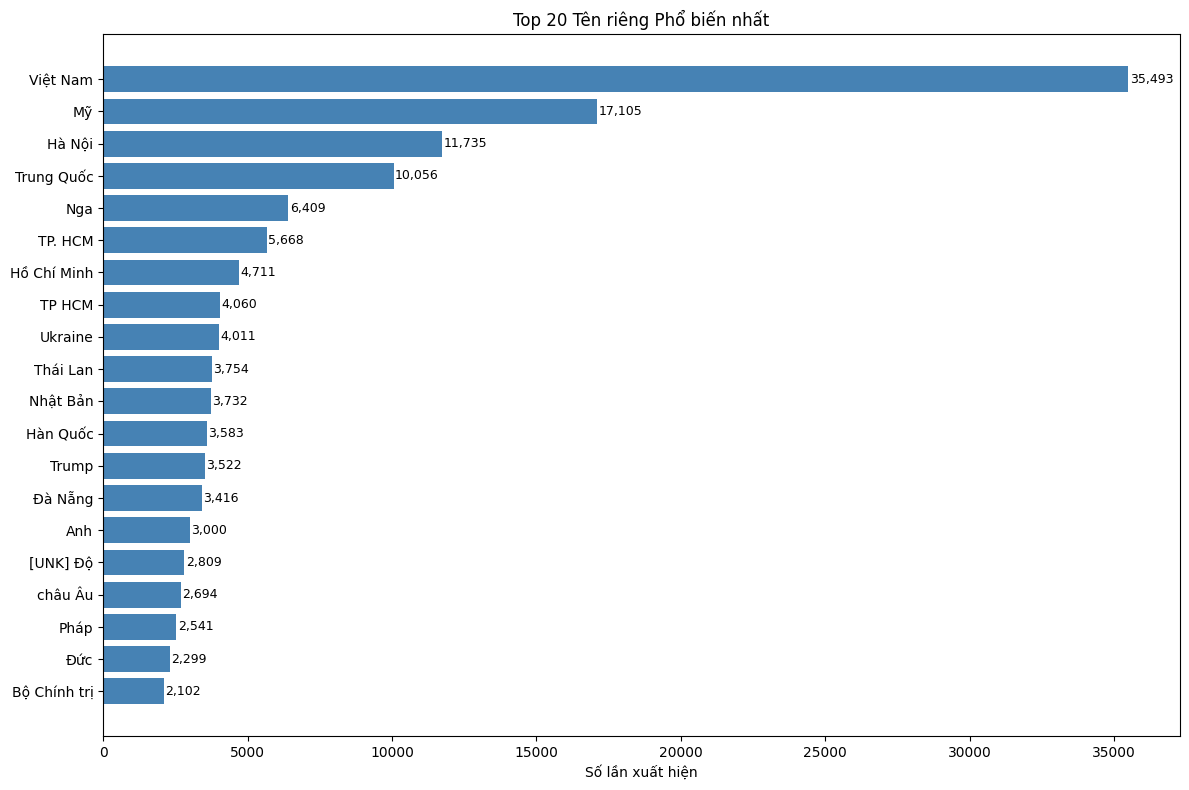

In [8]:
# Demo: Top 20 tên riêng
top20 = get_top_entities(20)

## 4. Chức năng 3: Tìm Tên riêng Liên quan

In [9]:
def get_related_entities(keyword, k=10, show_chart=True):
    """
    Tìm các tên riêng liên quan (đồng xuất hiện) với keyword.
    """
    related = co_occurrence.get(keyword, Counter())
    
    if not related:
        for key in co_occurrence:
            if key.lower() == keyword.lower():
                related = co_occurrence[key]
                keyword = key
                print(f"Sử dụng: '{key}'")
                break
    
    if related:
        top_related = related.most_common(k)
        
        print(f"\nCác tên riêng liên quan đến '{keyword}':")
        print("=" * 50)
        for i, (entity, count) in enumerate(top_related, 1):
            print(f"  {i:3}. {entity:30s} (đồng xuất hiện {count:,} lần)")
        
        if show_chart and HAS_MATPLOTLIB and len(top_related) > 0:
            entities = [e[0] for e in top_related][::-1]
            counts = [e[1] for e in top_related][::-1]
            
            fig, ax = plt.subplots(figsize=(10, max(4, k * 0.35)))
            bars = ax.barh(entities, counts, color='coral')
            ax.set_xlabel('Số lần đồng xuất hiện')
            ax.set_title(f'Tên riêng liên quan đến "{keyword}"')
            
            for bar, count in zip(bars, counts):
                ax.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2,
                       f'{count:,}', va='center', fontsize=9)
            
            plt.tight_layout()
            plt.show()
        
        return top_related
    else:
        print(f"Không tìm thấy thông tin liên quan cho '{keyword}'.")
        return []


Các tên riêng liên quan đến 'Huyền':
    1. Hà Nội                         (đồng xuất hiện 19 lần)
    2. Việt Nam                       (đồng xuất hiện 16 lần)
    3. Chu Thanh Huyền                (đồng xuất hiện 7 lần)
    4. Mỹ                             (đồng xuất hiện 5 lần)
    5. Nguyễn Thị Huyền               (đồng xuất hiện 5 lần)
    6. TP HCM                         (đồng xuất hiện 5 lần)
    7. Thanh Huyền                    (đồng xuất hiện 5 lần)
    8. Quang Hải                      (đồng xuất hiện 5 lần)
    9. Khánh Huyền                    (đồng xuất hiện 4 lần)
   10. Nam                            (đồng xuất hiện 4 lần)
   11. Long                           (đồng xuất hiện 4 lần)
   12. Kỳ                             (đồng xuất hiện 4 lần)
   13. Nam Định                       (đồng xuất hiện 3 lần)
   14. TP. HCM                        (đồng xuất hiện 3 lần)
   15. Hải Phòng                      (đồng xuất hiện 3 lần)


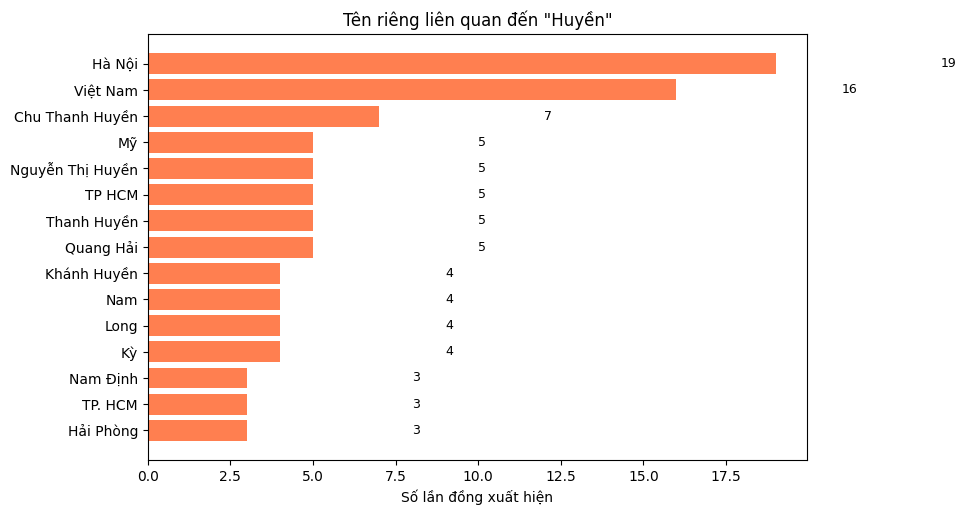

[('Hà Nội', 19),
 ('Việt Nam', 16),
 ('Chu Thanh Huyền', 7),
 ('Mỹ', 5),
 ('Nguyễn Thị Huyền', 5),
 ('TP HCM', 5),
 ('Thanh Huyền', 5),
 ('Quang Hải', 5),
 ('Khánh Huyền', 4),
 ('Nam', 4),
 ('Long', 4),
 ('Kỳ', 4),
 ('Nam Định', 3),
 ('TP. HCM', 3),
 ('Hải Phòng', 3)]

In [21]:
# Demo: Tìm tên liên quan đến "Hà Nội"
get_related_entities("Huyền", k=15)

## 5. Chức năng 4: Top N Cặp Tên riêng Đồng xuất hiện

In [11]:
def get_top_cooccurring_pairs(n=20, show_chart=True):
    """
    Lấy top N cặp tên riêng đồng xuất hiện nhiều nhất.
    """
    pairs = []
    seen = set()
    
    for e1, related in co_occurrence.items():
        for e2, count in related.items():
            pair_key = tuple(sorted([e1, e2]))
            if pair_key not in seen:
                seen.add(pair_key)
                pairs.append((e1, e2, count))
    
    pairs.sort(key=lambda x: -x[2])
    top_pairs = pairs[:n]
    
    print(f"\nTop {n} Cặp Tên riêng Đồng xuất hiện Nhiều nhất:")
    print("=" * 70)
    for i, (e1, e2, count) in enumerate(top_pairs, 1):
        print(f"  {i:3}. ({e1}, {e2}): {count:,} bài")
    
    if show_chart and HAS_MATPLOTLIB and len(top_pairs) > 0:
        labels = [f"{p[0]} + {p[1]}" for p in top_pairs][::-1]
        counts = [p[2] for p in top_pairs][::-1]
        
        fig, ax = plt.subplots(figsize=(12, max(6, n * 0.4)))
        bars = ax.barh(labels, counts, color='seagreen')
        ax.set_xlabel('Số bài đồng xuất hiện')
        ax.set_title(f'Top {n} Cặp Tên riêng Đồng xuất hiện Nhiều nhất')
        
        for bar, count in zip(bars, counts):
            ax.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2,
                   f'{count:,}', va='center', fontsize=8)
        
        plt.tight_layout()
        plt.show()
    
    return top_pairs


Top 20 Cặp Tên riêng Đồng xuất hiện Nhiều nhất:
    1. (Việt Nam, Hà Nội): 1,755 bài
    2. (Việt Nam, Mỹ): 1,449 bài
    3. (Việt Nam, Trung Quốc): 1,211 bài
    4. (Trung Quốc, Mỹ): 1,211 bài
    5. (Mỹ, Trump): 1,043 bài
    6. (Mỹ, Donald Trump): 1,040 bài
    7. (Việt Nam, Thái Lan): 907 bài
    8. (Việt Nam, Hồ Chí Minh): 899 bài
    9. (Nhật Bản, Việt Nam): 874 bài
   10. (TP. HCM, Việt Nam): 797 bài
   11. (Nga, Ukraine): 789 bài
   12. (Việt Nam, Hàn Quốc): 780 bài
   13. (Việt Nam, châu Á): 684 bài
   14. (Mỹ, Nga): 659 bài
   15. (Mỹ, châu Âu): 627 bài
   16. (Donald Trump, Trump): 621 bài
   17. (Việt Nam, Đông Nam Á): 563 bài
   18. (Hồ Chí Minh, Bác Hồ): 558 bài
   19. (Việt Nam, TP HCM): 553 bài
   20. (Việt Nam, Tô Lâm): 549 bài


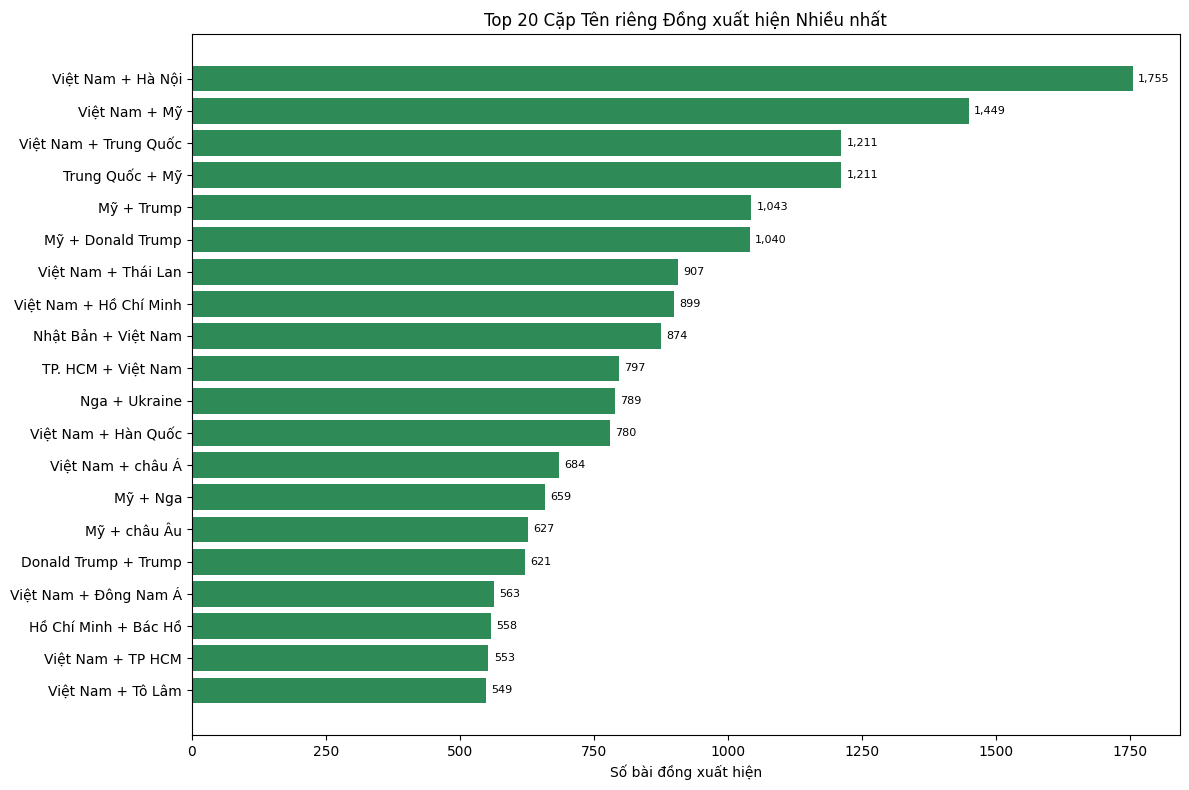

In [12]:
# Demo: Top 20 cặp đồng xuất hiện
top_pairs = get_top_cooccurring_pairs(20)

## 6. Network Graph

In [13]:
def draw_entity_network(center_entity, max_nodes=15, min_cooccurrence=5):
    """
    Vẽ mạng lưới các tên riêng liên quan.
    """
    if not HAS_MATPLOTLIB:
        print("Cần matplotlib. Chạy: pip install matplotlib")
        return
    
    try:
        import networkx as nx
    except ImportError:
        print("Cần networkx. Chạy: pip install networkx")
        return
    
    related = co_occurrence.get(center_entity, Counter())
    if not related:
        print(f"Không tìm thấy '{center_entity}'")
        return
    
    filtered = [(e, c) for e, c in related.most_common(max_nodes) if c >= min_cooccurrence]
    
    if not filtered:
        print(f"Không có tên riêng nào đồng xuất hiện >= {min_cooccurrence} lần")
        return
    
    G = nx.Graph()
    G.add_node(center_entity, size=3000, color='red')
    
    for entity, count in filtered:
        G.add_node(entity, size=500 + count * 50, color='skyblue')
        G.add_edge(center_entity, entity, weight=count)
    
    fig, ax = plt.subplots(figsize=(14, 10))
    pos = nx.spring_layout(G, k=2, iterations=50)
    
    node_sizes = [G.nodes[n].get('size', 500) for n in G.nodes()]
    node_colors = [G.nodes[n].get('color', 'skyblue') for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8, ax=ax)
    
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(edge_weights) if edge_weights else 1
    edge_widths = [1 + 4 * w / max_weight for w in edge_weights]
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, ax=ax)
    
    nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)
    edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8, ax=ax)
    
    ax.set_title(f'Mạng lưới tên riêng liên quan đến "{center_entity}"', fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

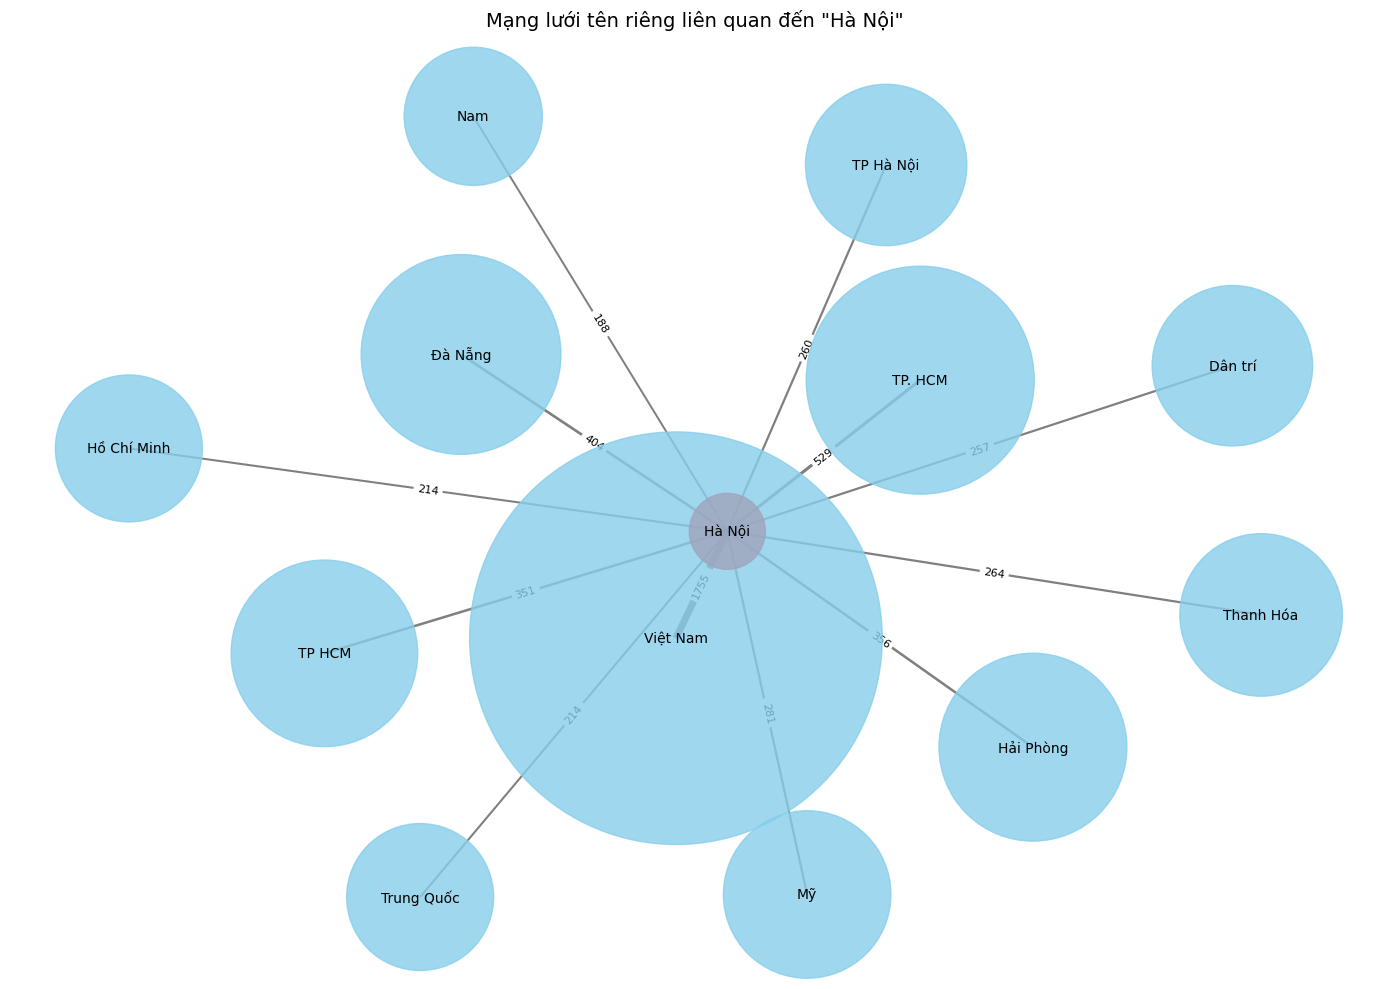

In [14]:
# Demo: Network graph cho "Hà Nội"
draw_entity_network("Hà Nội", max_nodes=12, min_cooccurrence=100)

## 7. Word Cloud

In [15]:
def generate_wordcloud(max_words=100):
    """
    Tạo Word Cloud từ các tên riêng.
    """
    if not HAS_MATPLOTLIB:
        print("Cần matplotlib. Chạy: pip install matplotlib")
        return
    
    try:
        from wordcloud import WordCloud
    except ImportError:
        print("Cần wordcloud. Chạy: pip install wordcloud")
        return
    
    word_freq = dict(entity_frequency.most_common(max_words))
    
    wc = WordCloud(
        width=1200, height=600,
        background_color='white',
        max_words=max_words,
        colormap='viridis'
    ).generate_from_frequencies(word_freq)
    
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title('Word Cloud - Tên riêng Phổ biến', fontsize=16)
    plt.tight_layout()
    plt.show()

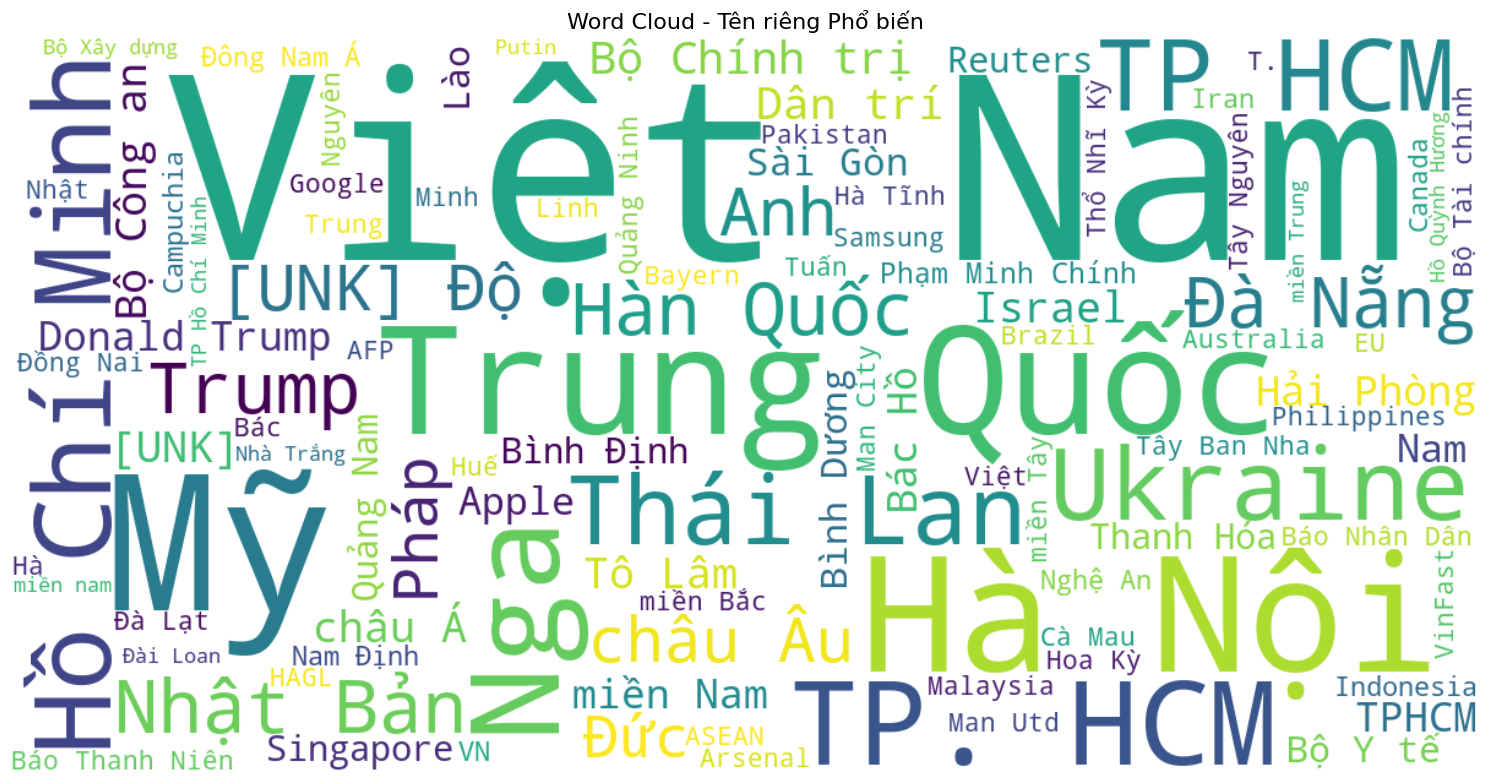

In [16]:
# Demo: Word Cloud
generate_wordcloud(100)

## 8. Export Kết quả ra CSV

In [17]:
def export_to_csv(filename='entities_report.csv'):
    """
    Xuất kết quả ra file CSV.
    """
    import csv
    
    with open(filename, 'w', encoding='utf-8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Rank', 'Entity', 'Frequency', 'Num_Articles'])
        
        for i, (entity, freq) in enumerate(entity_frequency.most_common(), 1):
            num_articles = len(inverted_index.get(entity, []))
            writer.writerow([i, entity, freq, num_articles])
    
    print(f"✓ Đã xuất {len(entity_frequency):,} entities ra file: {filename}")

In [18]:
# Export ra CSV
export_to_csv('entities_report.csv')

✓ Đã xuất 142,756 entities ra file: entities_report.csv


## 9. Thống kê Tổng quan

In [19]:
def show_statistics():
    print("=" * 60)
    print("THỐNG KÊ TỔNG QUAN")
    print("=" * 60)
    
    total_entities = len(inverted_index)
    total_occurrences = sum(entity_frequency.values())
    total_articles = len(set(f for files in inverted_index.values() for f in files))
    
    print(f"\n1. Số lượng tên riêng duy nhất: {total_entities:,}")
    print(f"2. Tổng số lần xuất hiện: {total_occurrences:,}")
    print(f"3. Số bài báo có tên riêng: {total_articles:,}")
    print(f"4. Trung bình tên riêng/bài: {total_occurrences / total_articles:.1f}")
    
    print("\n5. Top 5 tên riêng phổ biến nhất:")
    for i, (e, c) in enumerate(entity_frequency.most_common(5), 1):
        print(f"   {i}. {e}: {c:,}")

show_statistics()

THỐNG KÊ TỔNG QUAN

1. Số lượng tên riêng duy nhất: 142,756
2. Tổng số lần xuất hiện: 929,385
3. Số bài báo có tên riêng: 30,147
4. Trung bình tên riêng/bài: 30.8

5. Top 5 tên riêng phổ biến nhất:
   1. Việt Nam: 35,493
   2. Mỹ: 17,105
   3. Hà Nội: 11,735
   4. Trung Quốc: 10,056
   5. Nga: 6,409


---

## Tóm tắt các hàm

| Hàm | Mô tả |
|-----|-------|
| `search_entity("tên")` | Tìm bài báo chứa tên riêng |
| `get_top_entities(n)` | Top N tên riêng phổ biến |
| `get_related_entities("tên")` | Tên riêng liên quan |
| `get_top_cooccurring_pairs(n)` | Top N cặp đồng xuất hiện |
| `draw_entity_network("tên")` | Vẽ network graph |
| `generate_wordcloud()` | Tạo word cloud |
| `export_to_csv()` | Xuất CSV |